In [117]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [118]:
# loading the dataset
Stock = pd.DataFrame(yf.Ticker('AXP').history(period = 'max'))
stock_data = Stock.reset_index()
print(stock_data.shape)

prices = stock_data['Close']
prices.index = stock_data['Date']
print(prices.shape, type(prices))

(13115, 8)
(13115,) <class 'pandas.core.series.Series'>


In [119]:
# scaling the data to improve performance:
scaler = MinMaxScaler(feature_range=(0, 1))
norm_prices = np.array(scaler.fit_transform(prices.to_numpy().reshape(-1, 1)))

In [120]:
# setting the size of previous day samples taken in account
k = 60

x, y = [], []
for i in range(k, norm_prices.shape[0]):
    x.append(np.array(norm_prices[i-k:i, 0]))
    y.append(np.array(norm_prices[i, 0]))

x = np.stack(x)
y = np.stack(y)

# splitting train and test data (choosing the latest 20% to test out the performance)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10444, 60)
(2611, 60)
(10444,)
(2611,)


In [121]:
# defining the LSTM-based model

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(x_train.shape[-1], 1)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(60))
# model.add(keras.layers.LSTM(5))
model.add(keras.layers.Dense(50))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 30)             │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,441 (21.25 KB)

 Trainable params: 5,441 (21.25 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# compiling the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['r2_score']
)

In [123]:
# training the model
xt, xv, yt, yv = train_test_split(x_train, y_train, test_size=0.20)
history = model.fit(xt, yt, batch_size=1, epochs=5, verbose=2, validation_data=(xv, yv))

Epoch 1/5
8355/8355 - 35s - 4ms/step - loss: 0.0010 - r2_score: 0.7835 - val_loss: 5.5233e-05 - val_r2_score: 0.9889
Epoch 2/5
8355/8355 - 34s - 4ms/step - loss: 2.2794e-04 - r2_score: 0.9527 - val_loss: 5.6207e-05 - val_r2_score: 0.9887
Epoch 3/5
8355/8355 - 34s - 4ms/step - loss: 1.6450e-04 - r2_score: 0.9658 - val_loss: 1.6316e-04 - val_r2_score: 0.9672
Epoch 4/5
8355/8355 - 34s - 4ms/step - loss: 1.4502e-04 - r2_score: 0.9699 - val_loss: 1.7977e-04 - val_r2_score: 0.9638
Epoch 5/5
8355/8355 - 34s - 4ms/step - loss: 1.2181e-04 - r2_score: 0.9747 - val_loss: 1.1369e-04 - val_r2_score: 0.9771


In [124]:
# predicting the testing dataset values
y_preds = model.predict(x_test)

# reverting the scaling done for training
y_p = scaler.inverse_transform(y_preds)

# y_preds, today_pred = y_preds[:], y_preds[-1]
# print(y_preds.shape)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


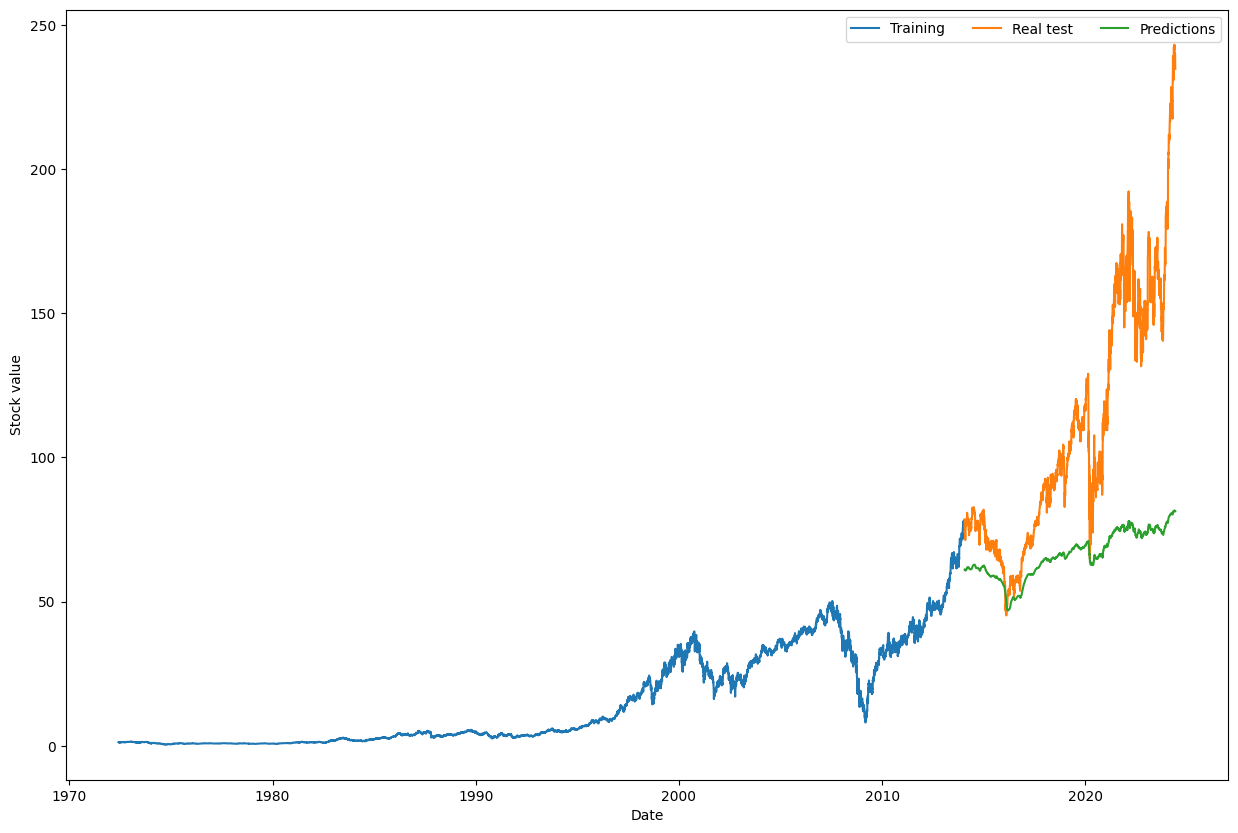

In [125]:
#Visualizando a Previsão
tr = prices[:x_train.shape[0]+k]
tst = prices[x_train.shape[0]+k:]
prd = pd.DataFrame(y_p, index=tst.index)

plt.figure(figsize=(15,10))
plt.ylabel('Stock value')
plt.xlabel('Date')
plt.plot(tr, label = "Training")
plt.plot(tst, label = 'Real test')
plt.plot(prd, label = 'Predictions')
plt.legend(ncol=3)
plt.show()